from matplotlib import pyplot as plt
import numpy as np
import random
import re
import sys
import pprint

In [541]:
# list of elements with name as key and [total electrons, valence electrons, usually used for bonds] as value
elemList = {'C':[6,4,4],'N':[7,5,3],'O':[8,6,2],'P':[15,5,3],'S':[16,6,2]} # 'Si':[14,4,4],'Cl':[17,7,1]
components = "CNOPS"
# number of charges we are sampling through
chargeList = range(-2,3)
# number of H atoms we are sampling through
hList = range(0,5)
            
class ligand():
    def __init__(self, name, numberOfHs, charge):
        self.name = name
        self.charge = charge
        self.numberOfHs = numberOfHs
        self.numberOfEs = self.getNumE()
        self.getNumE()
        
    def print_name(self):
        print(self.name)
    
    def print_charge(self):
        print(self.charge)
    
    def print_numberOfHs(self):
        print(self.numberOfHs)
    
    # CHARGES
    def setCharge(self,charge):
        self.charge = charge
        self.getNumE()
        
    def incrCharge(self):
        self.charge += 1
        self.getNumE()
        
    def decrCharge(self):
        self.charge -= 1
        self.getNumE()
        
    # HYDROGENS    
    def setH(self, number):
        self.numberOfHs = number
        self.getNumE()
    
    def addH(self):
        self.numberOfHs += 1
        self.getNumE()
        
    def rmH(self):
        self.numberOfHs -= 1
        self.getNumE()
        
    def getNumE(self):
        self.numLP = int((elemList[self.name][1] - elemList[self.name][2])/2)
        self.numValE = elemList[self.name][1]
        self.numE = elemList[self.name][0]
        mod = self.numberOfHs - self.charge
        self.numValE += mod
        self.numE += mod
        
    def getSmiles(self):
        """Generates a SMILES string. The first row adds hydrogen and the second row charges"""
        self.SMILES =  "[" + self.name + "".join(["H" for i in range(0,self.numberOfHs)]) 
        self.SMILES += "".join(["+" if self.charge > 0  else "-" for i in range(0,abs(self.charge))]) + "]"
    
    def testOctetRule(self):
        """Test whether a mono-heavy-atom ligand fulfills the octet rule. Results < 8 means that there are 
        too many electrons, result > 8 means that there are not enough electrons."""
        result = 8 - self.numValE
        return(result)
    
    def testValenceShell(self):
        """Since open shell complexes are difficult to converge in DFT, we restrict ourselves to closed shell ones."""
        result =  int(not self.numValE%2)
        return(result)
        
    def score(self):
        """The health score helps to prune the full enumeration by setting open shell ligands to zero and 
        weights ligands with negative charge more than ligands with positive charge. Greater is better in this
        score."""
#         score = (10-(-1*self.testOctetRule() if self.testOctetRule() < 0 else 0.5*self.testOctetRule())) #*self.testValenceShell() # removed the testValshell bc it is only relevant for the whole ligand
        score = 4-np.abs(int(self.testOctetRule())) 
        return(score)
    
    

All Monoatoms: 125
All selected monoatoms: 50
Name, Score = Charge + octet + CA
[10, 8, 1, 0, 3, 0, 1, 4, 3, 4, 3, 1, 10]
[NHHH]: 10 3 4 3
[10, 8, 2, -1, 1, 0, 1, 4, 3, 4, 3, 1, 10]
[OH-]: 10 3 4 3
[10, 8, 2, 0, 2, 0, 1, 4, 3, 4, 3, 1, 10]
[OHH]: 10 3 4 3
[18, 8, 1, 0, 3, 0, 1, 4, 3, 4, 3, 1, 10]
[PHHH]: 10 3 4 3
[18, 8, 2, -2, 0, 0, 1, 4, 3, 4, 3, 1, 10]
[S--]: 10 3 4 3
[18, 8, 2, 0, 2, 0, 1, 4, 3, 4, 3, 1, 10]
[SHH]: 10 3 4 3
Average SS: 10.0
Average All (\{0}): 7.2
Diff: 2.8




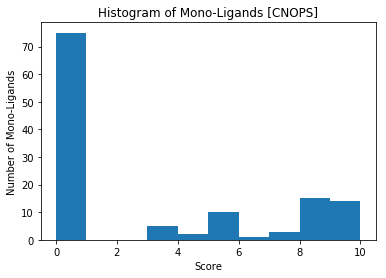

In [542]:
# generate exhaustive output list for mono-ligands
outputList = list()
dictMo = {}
for elem in elemList.keys():
    for charge in chargeList:
        l = ligand(elem, 0, 0)
        l.setCharge(charge)
        for h in hList:
            if h:
                l.addH()
            l.getSmiles()
            outputList.append([l.SMILES,l.numE,l.numValE,l.charge,l.testOctetRule(),l.testValenceShell(),l.score()]) 
            
            dictMo[l.SMILES] = [l.numE,l.numValE,l.numLP,l.charge,l.numberOfHs,\
                                l.testOctetRule(),l.testValenceShell(),l.score()]


# pprint.pprint(dictMo)    
print("All Monoatoms: " + str(len(dictMo)))  

for name, line in dictMo.items():
    charge = line[3]
    if charge <= 1 and line[4] < 5 and charge >= -3: # overall charge should not exceed +1 and not more than 4 H at CA (maybe change it to 3 as for diatoms)

        # charge score
        if charge > 0:
            scoreCharge = 0 #c1 #0
        if charge <= 0 and charge >= -2:
            scoreCharge = 3  #c2 #3
        elif charge == -3:
            scoreCharge = 0 #not 1 as in diatoms
#         elif charge == -4:
#             scoreCharge = 0 #c4 #0 disallow for -4 on monoatom

        # VSEPR score (no use for monoatoms)
#         usual1 = line[1] - 2*line[2] + line[3] - 2*line[4]
#         usual2 = line[9] - 2*line[10] + line[11] - 2*line[12]
#         scoreVsepr = 5-np.abs(usual1-usual2)  #v1=5

        # Coordinating Atom (CA) Sterics Score
        if line[4] == 4: #4 instead of 3 as for monoatoms
            scoreCa = 0 #ca1 #0
        else:
            scoreCa = 3 #ca2 #3

        # closed shell switch
        scoreClosedShell = int(not((line[1])%2))

        #total score
        # score = (scoreCharge + scoreVsepr + scoreCa + 0.5 * line[7] + 0.5 * line[15])*scoreClosedShell
        score = (scoreCharge + line[7] + scoreCa)*scoreClosedShell

        dictMo[name] = line + [scoreCharge] + [line[7]] + [scoreCa] + [scoreClosedShell] + [score] 

    else:
        score = 0.0
        dictMo[name] = line + [0] + [0] + [0] + [0] + [score]

k = 0 
scoreHist = list()
avgAll = list()
for name, prop in dictMo.items():
    scoreHist.append(prop[-1])
    if prop[-1] > 0:
        k += 1
        avgAll.append(prop[-1])
        
print("All selected monoatoms: " + str(k))        

scSeriesMo = ['[Cl-]', '[OH-]', '[S--]', '[OHH]', '[NHHH]',\
               '[PHHH]','[SHH]'] #up to NHHH from spectrochemical series, rest heather's excel

avgSS = list()
print("Name, Score = Charge + octet + CA")

histCharge = list()
histOctet = list()
histCa = list()
for name, props in dictMo.items():
    histCharge.append(props[-5])
    histOctet.append(props[-4])
    histCa.append(props[-3])
    for i in range(0, len(scSeriesMo)):
        if name == scSeriesMo[i]:
            print(props)
            print(name + ': '+ str(props[-1])+" "+str(props[-5])+" "+str(props[-4])+" "+str(props[-3])) 
            avgSS.append(props[-1])
print("Average SS: " + str(np.average(avgSS)))
print("Average All (\{0}): " + str(np.average(avgAll)))
print("Diff: " + str(np.average(avgSS) - np.average(avgAll)))
print('\n ================ \n')
diffs.append(np.average(avgSS) - np.average(avgAll))



plt.xlabel('Score')
plt.ylabel('Number of Mono-Ligands')
# plt.yscale('log', nonposy='clip')
plt.title('Histogram of Mono-Ligands ['+ components + "]")
plt.hist(scoreHist)
# plt.savefig('distr_' + components + ".pdf", bbox_inches='tight')
plt.show()



[2,
 3,
 4,
 3,
 2,
 1,
 2,
 3,
 4,
 3,
 0,
 1,
 2,
 3,
 4,
 -1,
 0,
 1,
 2,
 3,
 0,
 0,
 0,
 0,
 0,
 3,
 4,
 3,
 2,
 1,
 2,
 3,
 4,
 3,
 2,
 1,
 2,
 3,
 4,
 3,
 0,
 1,
 2,
 3,
 4,
 0,
 0,
 0,
 0,
 0,
 4,
 3,
 2,
 1,
 0,
 3,
 4,
 3,
 2,
 1,
 2,
 3,
 4,
 3,
 2,
 1,
 2,
 3,
 4,
 3,
 0,
 0,
 0,
 0,
 0,
 3,
 4,
 3,
 2,
 1,
 2,
 3,
 4,
 3,
 2,
 1,
 2,
 3,
 4,
 3,
 0,
 1,
 2,
 3,
 4,
 0,
 0,
 0,
 0,
 0,
 4,
 3,
 2,
 1,
 0,
 3,
 4,
 3,
 2,
 1,
 2,
 3,
 4,
 3,
 2,
 1,
 2,
 3,
 4,
 3,
 0,
 0,
 0,
 0,
 0]

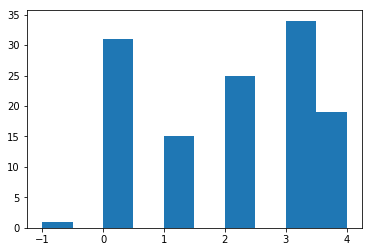

In [536]:
plt.hist(histOctet)
histOctet

All diatoms: 5625
All selected diatoms: 1498
Name, Score = Charge + VSEPR + CA
[C-][N]: 10 3 4 3
[C][NH]: 9 3 3 3
[C][O]: 9 3 3 3
[C-][P]: 10 3 4 3
[C][PH]: 9 3 3 3
[C][S]: 9 3 3 3
[N-][C]: 10 3 4 3
[N][CH]: 11 3 5 3
[N+][O]: 7 0 4 3
[N][P]: 11 3 5 3
[N+][S]: 7 0 4 3
[O][C]: 9 3 3 3
[O+][N]: 7 0 4 3
[O--][O]: 11 3 5 3
[O-][OH]: 10 3 4 3
[O+][P]: 7 0 4 3
[O++][P]: 0.0 0 0 0
[P-][C]: 10 3 4 3
[P][CH]: 11 3 5 3
[P][N]: 11 3 5 3
[P+][O]: 7 0 4 3
[P+][S]: 7 0 4 3
[S][C]: 9 3 3 3
[S+][N]: 7 0 4 3
[S++][O]: 0.0 0 0 0
[S+][P]: 7 0 4 3
[S--][S]: 11 3 5 3
[S-][SH]: 10 3 4 3
Average SS: 8.428571428571429
Average All (\{0}): 7.210280373831775
Diff: 1.2182910547396535




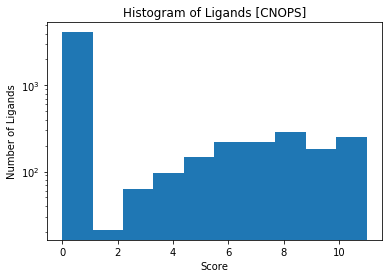

In [493]:
# re.sub('[\]\[]','',diatomName) # remove the brackets

# generate exhaustive output list for di-ligands
outputListDi = list()
dictDi = {}

for elem1 in elemList.keys():
    for elem2 in elemList.keys():
        for charge1 in range(-4,5):
#         for charge2 in chargeList:
#             idea: only use charge1 on one but from -4 to +4, because charge is not localized in dft
            for h1 in hList:
                for h2 in hList: 
                    l1 = ligand(elem1, 0, 0)
                    l1.setCharge(charge1)
                    l1.setH(h1)
                    l2 = ligand(elem2, 0, 0)
                    l2.setCharge(0)
                    l2.setH(h2)

                    l1.getSmiles()
                    l2.getSmiles()

                    diatomName = ''.join(l1.SMILES + l2.SMILES)

                    dictDi[diatomName] = [l1.numE, l1.numValE, l1.numLP, l1.charge, l1.numberOfHs, \
                                         l1.testOctetRule(), l1.testValenceShell(), l1.score(),\
                                         l2.numE, l2.numValE, l2.numLP, l2.charge, l2.numberOfHs, \
                                         l2.testOctetRule(), l2.testValenceShell(), l2.score()]

#                     outputListDi.append([l1.SMILES, \
#                                              l1.numE, l1.numValE, l1.numLP, l1.charge, l1.numberOfHs, \
#                                              l1.testOctetRule(), l1.testValenceShell(), l1.score(),\
#                                              l2.SMILES,
#                                              l2.numE, l2.numValE, l2.numLP, l2.charge, l2.numberOfHs, \
#                                              l2.testOctetRule(), l2.testValenceShell(), l2.score()])
print("All diatoms: " + str(len(dictDi)))

# net charge <+1
# vsepr
# sterics (ca)
# closed shell (even #e)
# octet rule

for name, line in dictDi.items():
    charge = line[3]
    if charge <= 1 and line[4] < 4: # overall charge should not exceed +1 and not more than 3 H at CA

        # charge score
        if charge > 0:
            scoreCharge = 0 #c1 #0
        if charge <= 0 and charge >= -2:
            scoreCharge = 3  #c2 #3
        elif charge == -3:
            scoreCharge = 1 #c3 #1
        elif charge == -4:
            scoreCharge = 0 #c4 #0

        # VSEPR score
        usual1 = line[1] - 2*line[2] + line[3] - 2*line[4]
        usual2 = line[9] - 2*line[10] + line[11] - 2*line[12]
        scoreVsepr = 5-np.abs(usual1-usual2)  #v1=5

        # Coordinating Atom (CA) Sterics Score
        if line[4] == 3:
            scoreCa = 0 #ca1 #0
        else:
            scoreCa = 3 #ca2 #3

        # closed shell switch
        scoreClosedShell = int(not((line[1]+line[9])%2))

        #total score
        # score = (scoreCharge + scoreVsepr + scoreCa + 0.5 * line[7] + 0.5 * line[15])*scoreClosedShell
        score = (scoreCharge + scoreVsepr + scoreCa)*scoreClosedShell

        dictDi[name] = line + [scoreCharge] + [scoreVsepr] + [scoreCa] + [scoreClosedShell] + [score] 
    else:
        score = 0.0
        dictDi[name] = line + [0] + [0] + [0] + [0] + [score]

# pprint.pprint(dictDi) # weird presentation
# print(dictDi['[NHH---][CHHHH]'][-1])

k = 0 
scoreHist = list()
avgAll = list()
for name, prop in dictDi.items():
    scoreHist.append(prop[-1])

    if prop[-1] > 0:
        k += 1
        avgAll.append(prop[-1])
print("All selected diatoms: " + str(k))        

scSeriesDi = ['[S--][S]', '[C-][N]', '[N-][C]', '[C][O]', '[N+][O]', '[O--][O]',\
             '[C][NH]','[C-][P]','[C][PH]','[C][S]','[N][CH]','[N][P]','[N+][S]',\
             '[O][C]','[O+][N]','[O+][P]','[O++][P]','[P-][C]','[P][CH]','[P][N]',\
             '[P+][O]','[P+][S]','[S][C]','[S+][N]','[S++][O]','[S+][P]',\
             '[O-][OH]','[S-][SH]'] # up to O22- is from wiki, rest from heather's table

avgSS = list()
print("Name, Score = Charge + VSEPR + CA")

histCharge = list()
histVsepr = list()
histCa = list()
for name, props in dictDi.items():
    histCharge.append(props[-5])
    histVsepr.append(props[-4])
    histCa.append(props[-3])
    for i in range(0, len(scSeriesDi)):
        if name == scSeriesDi[i]:
#             print(props)
            print(name + ': '+ str(props[-1])+" "+str(props[-5])+" "+str(props[-4])+" "+str(props[-3])) 
#                                         TODO store all score parts in list and hist them to see score distr.
#                                         TODO run over different param of score to see how to separate SS best from rest.
            avgSS.append(props[-1])
print("Average SS: " + str(np.average(avgSS)))
print("Average All (\{0}): " + str(np.average(avgAll)))
print("Diff: " + str(np.average(avgSS) - np.average(avgAll)))
# print(params)
print('\n ================ \n')
diffs.append(np.average(avgSS) - np.average(avgAll))



plt.xlabel('Score')
plt.ylabel('Number of Di-Ligands')
plt.yscale('log', nonposy='clip')
plt.title('Histogram of Ligands ['+ components + "]")
plt.hist(scoreHist)
# plt.savefig('distr_' + components + ".pdf", bbox_inches='tight')
plt.show()





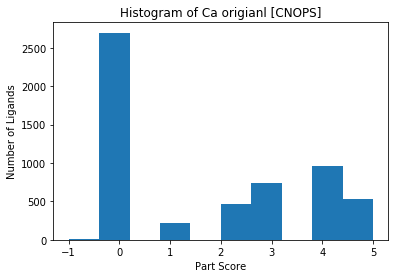

In [403]:
# plt.xlabel('Part Score')
# plt.ylabel('Number of Ligands')
# # plt.yscale('log', nonposy='clip')
# plt.title('Histogram of Ca origianl ['+ components + "]")
# plt.hist(histVsepr)
# # plt.savefig('histCa' + components + ".pdf", bbox_inches='tight')
# plt.show()

In [317]:
# first version of scoring

# ## only negatively charged ligands
# outputListDiNeg = []
# scoreDiNeg = []
# for line in outputListDi:
#     # only consider negatively charged di-heavy-atoms
#     if line[4] <= 0 or line[13] <= 0:
#         # higher is better
#         scoreCharge = 3 if line[4] + line[13] >= -2 else line[4] + line[13] + 4
#         scoreCharge -= 3 if line[4] + line[13] > 0 else 0

#         usual1 = line[2] - 2*line[3] + line[4] - 2*line[5]
#         usual2 = line[11] - 2*line[12] + line[13] - 2*line[14]
#         scoreVsepr = 5-np.abs(usual1-usual2)
        
#         # THEY ARENT[[since both AB and BA is created, we remove the ones that are A=B]]
#         # the first atom is the CA and we punish >=3 H on it.
#         if line[5] == 4:
#             scoreCa = 0
#         elif line[5] == 3:
#             scoreCa = 1
#         else:
#             scoreCa = 4
        
#         scoreClosedShell = int(not((line[2]+line[11])%2))

#         score = (scoreCharge + scoreVsepr + scoreCa + 0.5 * line[8] + 0.5 * line[17])*scoreClosedShell
#         scoreDiNeg.append(score)
        
#         outputListDiNeg.append([line,score])
#     else:
#         continue

# # gives 5625 (total 15625 * 9/25, since there are 25 comb of [-2,+2], 9 of which contain a pos sign)    

# # for s in outputListDiNeg:
# #     print(*s)
# k=0
# score = np.zeros(len(outputListDiNeg))
# for i in range(0, len(outputListDiNeg)):
#     score[i] = outputListDiNeg[i][1]
#     if score[i] > 3:
#         k += 1
# #         print(outputListDiNeg[i])
# print(k)    

# plt.xlabel('Score')
# plt.ylabel('Number of Ligands')
# plt.title('Histogram of Ligands ['+ components + "]")
# plt.hist(score)
# # plt.savefig('distr_' + components + ".pdf", bbox_inches='tight')
# plt.show()



In [40]:
# create list of isoelectronic ligands and ve-isoelectronig ligands (ligands that have the same amount of VE)
isoList = []  
veList = []
score = []
for line in outputList:
    isoList.append(line[1]) # unsorted list of the total amount of e
    veList.append(line[2]) # unsorted list of the amount of VE
    score.append(line[-1])

isoLigands = {} # dictionary of ligands with key: number of electrons, values: the whole output
d = dict()
for i in np.unique(isoList):
    d[i] = []

for line in outputList:
    d[line[1]].append(line)

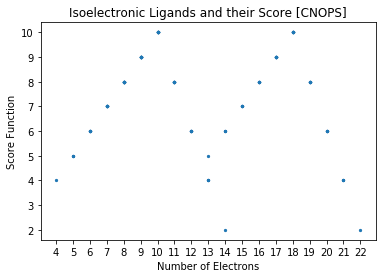

In [41]:
# plot of score function vs number of total electrons. It seems like the number of electrons determines the score fullz.
plt.scatter(isoList, score, s = 5)
plt.xlabel('Number of Electrons')
plt.ylabel('Score Function')
plt.title('Isoelectronic Ligands and their Score ['+ components + "]")
plt.xticks(np.unique(isoList))
plt.savefig('score_iso_ligands_' + components + ".pdf", bbox_inches='tight')
plt.show()


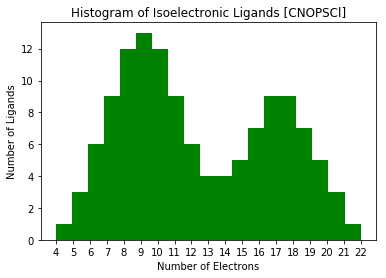

In [73]:
# plot the number of ligands sorted by the number of electrons (isoelectronic structures)

numBins = len(np.unique(isoList))

plt.hist(isoList, bins = numBins, facecolor='green')
plt.xlabel('Number of Electrons')
plt.ylabel('Number of Ligands')
plt.title('Histogram of Isoelectronic Ligands ['+ components + "]")
plt.xticks(np.unique(isoList))
# plt.savefig('hist_iso_ligands_' + components + ".pdf", bbox_inches='tight')
plt.show()


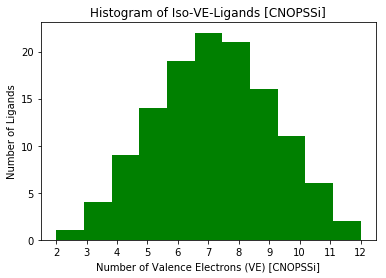

In [78]:
# plot the number of ligands sorted by the number of VE (VE-isoelectronic structures)

numBins = len(np.unique(veList))

plt.hist(veList, bins = numBins, facecolor='green')
plt.xlabel('Number of Valence Electrons (VE) ['+ components + "]")
plt.ylabel('Number of Ligands')
plt.title('Histogram of Iso-VE-Ligands ['+ components + "]")
plt.xticks(np.unique(veList))
# plt.savefig('hist_isove_ligands_' + components + ".pdf", bbox_inches='tight')
plt.show()
